# Cadeia de suprimentos global de 1998 a 2017 (Divisão de Estatística das Nações Unidas)


## Breve explicação sobre a base, formalização do problema e objetivo.

**Em virtude de diversos tratados mundiais, a exposição dos montantes financeiros referentes ao fornecimento de produtos é definida como instrumento de transparência financeira e desenvolvimento mútuo das nações.** 

**A presente base de dados é acessível por meio da plataforma COMTRADE (sob responsabilidade da United Nations Statistical Division) e pelo Centro para Dados Internacionais Robert Feenstral. Todos os produtos estão categorizados usando os padrões SITC (Standard International Trade Classification) ou HS (Harmonized System), criados para facilitar a operação e tradução de regras tributárias no comércio internacional.**

![ONU COMTRADE - Global Supply Chain](img/comtrade.png)


**Toda cadeia produtiva visa o suprimento de uma demanda e necessita de diversas organizações para o fornecimento de matérias primas, produção do bem de consumo e distribução para o público alvo. Por isso, é ideal que haja implementação e compartilhamento de métricas entre organizações relacionadas. Estas podem ser organizadas de forma hierarquica, partindo das métricas focadas em componentes isolados, a partir das quais o diagnóstico de estruturas com objetivos comuns são definidos, e rotinas preditivas são executadas.**

****

![Supply Chain Metrics](img/Supply_Metrics.png)

****
**Uma vez que cadeias de suprimento podem ser modeladas como redes complexas, e existem precedentes sobre predição em grafos por rotinas de mineração de dados, a presente base é suficientemente completa e robusta para experimentação de rotinas de predição em redes complexas dinâmicas e faltantes**

**Proposição do Problema:**

A partir de uma rede complexa dinâmica em larga e multi escala, com agentes e relações que se alteram com o tempo, e histórico faltante, como gerar rotinas de predição com erro controlável?

**Formalização do problema:**

Dado uma rede complexa dinâmica $$ G_t = \{E_t, V_t\}, t \geq 0$$

 $$V_t = \{v_{i,t},  i \in [0,N] |  N \rightarrow \infty \}$$ onde $v_{i,t}$ é uma variável aleatória
 
 $$E_t = \{(v_{i,t}, v_{j,t}, w) | v_{i,t}, v_{j,t} \in V_t\ , w \in \mathbb{R} \}$$
 
Propor algoritmo F, tal que:
 
$$F(Q) = G_{q,t+k} + \varepsilon, k \geq 1, Q \subset \{G_t, G_{t-1}, ... , G_0\}, Q << G_{t-u}, \forall u \geq 0, \varepsilon \sim N(0,1)$$

<!-- $$F(Q) = E_{q,t+k} + \varepsilon, k \geq 1, Q \subset \{E_t, E_{t-1}, ... , E_0\}, Q << E_{t-u}, \forall u \geq 0, \varepsilon \sim N(0,1)$$ -->



# Pré-requisitos, importação e Parametros Globais

In [ ]:
# API Banco de dados, Estrutura Otimizada para Manipulação com Banco, Visualização, e Biblioteca para Grafos
!pip install pydata_google_auth pandas_gbq seaborn networkx

In [2]:
import pandas as pd
import pydata_google_auth
import seaborn as sns 
import matplotlib.pyplot as plt 
import networkx as nx 

In [3]:
#formatação dos resultados com ponto flutuante
pd.set_option('float_format', '{:f}'.format) 

#rota para credenciais do banco 
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

#base de dados analisada (Sintaxe: BigQuery)
database_path = "`silent-elevator-193921.OEC_DataSources.n0_year_origin_destination_hs96_6`"

# Sumário - Descritiva Básica

1. Schema e Domínio dos dados 
    1. Tuplas exemplos
    2. Dicionário de dados 
    3. Fontes de dados xuxiliares 


2. Estatísticas Gerais 
    1. Período analisado, quantidade de tuplas, países de origem/destino e produtos distintos 
    2. Montantes Anuais (Financeiro, #Produtos, #Países)
    3. Montantes por País (Financeiro, #Produtos, #Fornecedores, #Consumidores) 
    4. Montantes por Produto 


3. Histórico de Importação e Exportação 
    1. Definição Séries Temporais (Uni e Multivariada)
    2. Volume de séries temporais uni e multivariadas 
    3. Distribuição dos valores de séries temporais e séries de retorno 
    4. Distância entre séries temporais (uni e multivariadas)


<!-- 4. Grafos Temporal Direcionado 
    1. Definição
    2. Distribuição de grau e ordem 
    3. Centralidade, Fluxo e o que mais? -->

# 1) Schema e Domínio dos dados 

## 1.A) Exemplos de registros 

In [63]:
#Amostra do Schema original 
sample_query = """
SELECT 
    *
FROM 
    {database_path}
limit 100;

""".format(database_path = database_path)

sample = pd.read_gbq(sample_query, 
                         project_id="silent-elevator-193921", 
                             dialect='standard', credentials=credentials)

sample

,year,origin,dest,hs96,export_val,import_val
0,2014,usa,afg,842389,180074.00,None
1,2002,xxb,jpn,390599,None,2705577.00
2,2001,hun,mex,392059,None,2867.02
3,2015,dnk,nor,282751,14135.07,None
4,2017,aut,per,901580,39564.96,None
...,...,...,...,...,...,...
95,2005,sau,are,392510,439449.90,50325.25
96,1998,are,deu,721123,None,33000.00
97,2017,tha,sur,200980,126641.08,None
98,2015,gbr,tha,320300,652813.71,None


## 1.B) Dicionário de dados 

**Year** - Ano fiscal referente à transação comercial 

**origin** - País origem do produto 

**dest** - País destino do produto 

**hs96** - Código HS na Modalidade 96 - qualificação tributária do produto 

**export_val** - valor de exportação em milhões de dólares (origem - fornecedor, destino - consumidor)

**import_val** - valor de imporação em milhões de dólares (origem - fornecedor, destino - consumidor) 


## 1.C) Fontes de Dados Auxiliares 

In [213]:
#Tabela com abreviações oficiais de todos os países
country_abreviations = pd.read_csv("../raw_data/decompressed/country_names.tsv", delimiter="\t")
country_abreviations.head()

,id,id_3char,name
0,afago,ago,Angola
1,afbdi,bdi,Burundi
2,afben,ben,Benin
3,afbfa,bfa,Burkina Faso
4,afbwa,bwa,Botswana


In [214]:
#Tabela com descrição dos códigos tributários
hs96_code = pd.read_csv("../raw_data/decompressed/products_hs_96.tsv", 
                                names ={"id":str, "hs96":str, "name":str },
                                    delimiter="\t")
hs96_code = hs96_code.iloc[1:]
hs96_code.head()

,id,hs96,name
1,010101,0101,"Live horses, asses, mules and hinnies"
2,01010111,010111,"Horses, Live"
3,01010119,010119,"Horses, Live"
4,01010120,010120,"Asses, Mules And Hinnies, Live"
5,010102,0102,Live bovine animals


# 2) Estatísticas Gerais

## 2.A) Período analisado, quantidade de tuplas, países de origem/destino e produtos distintos

In [83]:
#Período analisado, quantidade de tuplas, países de origem/destino e produtos distintos
trade_initial_stats_query = """
SELECT 

min(year) as first_year,

max(year) as last_year, 

count(1) as tuples, 

count(distinct origin) as origin,

count(distinct dest) as destiny, 

count(distinct hs96) as products,

sum(cast(import_val as float64)) as import_financial_volume,

sum(cast(export_val as float64)) as export_financial_volume,

FROM 
    {database_path}

""".format(database_path = database_path)

general_stats = pd.read_gbq(trade_initial_stats_query,
                                project_id="silent-elevator-193921", 
                                    dialect='standard', credentials=credentials)
general_stats

,first_year,last_year,tuples,origin,destiny,products,import_financial_volume,export_financial_volume
0,1998,2017,191146120,238,238,5111,199582357229157.312500,200400389589734.250000


## 2.B) Montantes Anuais (Financeiro, #Produtos, #Países)

In [215]:
#Período analisado, quantidade de tuplas, países de origem/destino e produtos distintos
annual_stats_query = """
SELECT 

Year, 
count(distinct hs96) as unique_products, 
sum(cast(import_val as float64)) as import_financial_volume, 
sum(cast(export_val as float64)) as export_financial_volume, 
count(distinct origin) as origin, 
count(distinct dest) as dest

FROM 
    {database_path}

group by 1 order by 1 desc 
""".format(database_path = database_path)

annual_stats = pd.read_gbq(annual_stats_query,
                                project_id="silent-elevator-193921", 
                                    dialect='standard', credentials=credentials)
annual_stats

,Year,unique_products,import_financial_volume,export_financial_volume,origin,dest
0,2017,4914,16296773195866.294922,16296773195866.201172,221,221
1,2016,5002,15290714940499.144531,15290714940499.150391,221,221
2,2015,5007,15695105719349.806641,15695105719349.812500,221,221
3,2014,5015,18145545684633.312500,18145545684633.246094,221,221
4,2011,5013,10582342178502.113281,11400374539074.945312,127,231
5,2010,5048,14860026873213.837891,14860026873213.802734,231,231
6,2009,5075,12143489091388.326172,12143489091388.263672,231,231
7,2008,5078,15962687202147.230469,15962687202147.189453,231,231
8,2007,5097,13401591308843.498047,13401591308843.529297,231,231
9,2006,5104,11803251125420.642578,11803251125420.673828,231,231


## 2.C) Montantes por País (Financeiro, #Produtos, #Fornecedores, #Consumidores)

In [ ]:
#Período analisado, quantidade de tuplas, países de origem/destino e produtos distintos
country_annual_stats_query = """
With 
buy as ( 
    SELECT 
        Year, 
        dest as name,
        count(distinct hs96) as import_products, 
        sum(cast(import_val as float64)) as import_val, 
        count(distinct origin) as Suppliers, 

    FROM 
        {database_path}
    GROUP BY 1,2
), 

sell as ( 
    SELECT 
        Year, 
        origin as name,
        count(distinct hs96) as export_products, 
        sum(cast(export_val as float64)) as export_val, 
        count(distinct dest) as Customers, 

    FROM 
        {database_path}
    GROUP BY 1,2
)


select * from buy full outer join sell using(year, name)


""".format(database_path = database_path)

country_annual_stats = pd.read_gbq(country_annual_stats_query,
                                project_id="silent-elevator-193921", 
                                    dialect='standard', credentials=credentials)



In [108]:
country_annual_stats.describe()

,import_products,import_val,Suppliers,export_products,export_val,Customers
count,4099.000000,4098.000000,4099.000000,3995.000000,3994.000000,3995.000000
mean,3266.854355,48702380973.440643,125.319346,3291.314894,50175360438.090279,128.581727
std,1466.257837,156207333586.261963,59.625730,1454.822274,161602702428.316162,59.459302
min,2.000000,4668.920000,1.000000,2.000000,8401.000000,1.000000
25%,2280.500000,194734597.422500,78.000000,2316.000000,207874446.882500,81.000000
50%,3683.000000,2347155258.210000,127.000000,3718.000000,2390136037.874999,134.000000
75%,4543.000000,21813011360.297501,177.000000,4554.000000,22452119039.574997,180.000000
max,5110.000000,2433991665236.530273,225.000000,5110.000000,2433991665236.531738,225.000000


In [114]:
country_annual_stats.corr(method="spearman")

,import_products,import_val,Suppliers,export_products,export_val,Customers
import_products,1.000000,0.916957,0.905140,0.999712,0.916001,0.916454
import_val,0.916957,1.000000,0.828837,0.917768,0.999482,0.852484
Suppliers,0.905140,0.828837,1.000000,0.905485,0.831883,0.981285
export_products,0.999712,0.917768,0.905485,1.000000,0.917043,0.917216
export_val,0.916001,0.999482,0.831883,0.917043,1.000000,0.852812
Customers,0.916454,0.852484,0.981285,0.917216,0.852812,1.000000


In [113]:
country_annual_stats.corr(method="pearson")

,import_products,import_val,Suppliers,export_products,export_val,Customers
import_products,1.000000,0.330592,0.892148,0.999665,0.327578,0.904774
import_val,0.330592,1.000000,0.385724,0.329727,0.993348,0.393795
Suppliers,0.892148,0.385724,1.000000,0.893113,0.376107,0.982979
export_products,0.999665,0.329727,0.893113,1.000000,0.327467,0.905268
export_val,0.327578,0.993348,0.376107,0.327467,1.000000,0.392189
Customers,0.904774,0.393795,0.982979,0.905268,0.392189,1.000000


## 2.D) Montantes por Produtos (Financeiro, #Países, #Fornecedores, #Consumidores)

In [216]:
#Período analisado, quantidade de tuplas, países de origem/destino e produtos distintos
product_annual_stats_query = """

    SELECT 
        Year, 
        hs96,
        sum(cast(import_val as float64)) as financial_volume, 
        count(distinct case when import_val is null then origin end) as Suppliers,
        count(distinct case when export_val is null then origin end) as Customer,
        Count(distinct year) as years
    FROM 
        {database_path}
    GROUP BY 1,2

""".format(database_path = database_path)

product_annual_stats = pd.read_gbq(product_annual_stats_query,
                                project_id="silent-elevator-193921", 
                                    dialect='standard', credentials=credentials)



In [217]:
product_annual_stats.describe()

,financial_volume,Suppliers,Customer,years
count,90979.000000,90991.000000,90991.000000,90991.000000
mean,2193718959.640793,74.204229,136.053994,1.000000
std,16805522894.047644,31.064889,49.836836,0.000000
min,1011.000000,0.000000,0.000000,1.000000
25%,134933329.435000,53.000000,103.000000,1.000000
50%,427699774.930000,73.000000,143.000000,1.000000
75%,1308929572.474999,94.000000,177.000000,1.000000
max,1708864887455.000244,210.000000,227.000000,1.000000


In [218]:
product_annual_stats.corr(method="pearson")

,financial_volume,Suppliers,Customer,years
financial_volume,1.000000,0.178139,0.093910,nan
Suppliers,0.178139,1.000000,0.864231,nan
Customer,0.093910,0.864231,1.000000,nan
years,nan,nan,nan,nan


In [219]:
product_annual_stats.corr(method="spearman")

,financial_volume,Suppliers,Customer,years
financial_volume,1.000000,0.660908,0.616476,nan
Suppliers,0.660908,1.000000,0.882880,nan
Customer,0.616476,0.882880,1.000000,nan
years,nan,nan,nan,nan


In [220]:
#produtos com maiores volumes financeiros
product_annual_stats.merge(hs96_code, on="hs96").sort_values("financial_volume", ascending=False).head()

,Year,hs96,financial_volume,Suppliers,Customer,years,id,name
57204,2008,270900,1708864887455.000244,113,148,1,05270900,Petroleum Oils And Oils From Bituminous Minera...
57208,2014,270900,1422498760732.710205,116,138,1,05270900,Petroleum Oils And Oils From Bituminous Minera...
57206,2010,270900,1382118465496.750244,120,144,1,05270900,Petroleum Oils And Oils From Bituminous Minera...
57207,2011,270900,1100695540655.370361,78,83,1,05270900,Petroleum Oils And Oils From Bituminous Minera...
57203,2007,270900,1091546313879.479980,115,150,1,05270900,Petroleum Oils And Oils From Bituminous Minera...


In [221]:
#produtos com menores volumes financeiros
product_annual_stats.merge(hs96_code, on="hs96").sort_values("financial_volume", ascending=True).head()

,Year,hs96,financial_volume,Suppliers,Customer,years,id,name
64456,2015,851992,1011.000000,1,1,1,16851992,"Sound Reproducing Apparatus, N.E.S."
19089,2014,330126,1014.000000,1,1,1,06330126,"Essential Oils, Except Of Citrus Fruit"
85862,2017,621310,1026.000000,1,1,1,11621310,"Handkerchiefs, Not Knitted Or Crocheted"
84185,2003,293970,1033.000000,1,1,1,06293970,Nicotine And Its Salts
50107,2015,901049,1045.000000,1,1,1,18901049,Apparatus And Equipment For Photographic (Incl...


In [181]:
#Produtos mais comuns em fornecimento
product_annual_stats.merge(hs96_code, on="hs96").sort_values("Suppliers", ascending=False).head()

,Year,hs96,financial_volume,Suppliers,Customer,name,id
38538,2006,847330,193720709526.500000,210,224,Parts Of Automatic Data Processing Machines An...,16847330
13465,2008,392690,41849992495.169998,203,221,"Articles Of Plastics, N.E.S.",07392690
38539,2007,847330,139482290203.680023,203,218,Parts Of Automatic Data Processing Machines An...,16847330
38540,2008,847330,131711424286.029999,200,215,Parts Of Automatic Data Processing Machines An...,16847330
38535,2003,847330,142985413463.210022,200,223,Parts Of Automatic Data Processing Machines An...,16847330


In [182]:
#Produtos menos comuns em fornecimento
product_annual_stats.merge(hs96_code, on="hs96").sort_values("Suppliers", ascending=True).head()

,Year,hs96,financial_volume,Suppliers,Customer,name,id
79683,2011,370220,1093.000000,0,1,"Photographic Film In Rolls, Sensitised, Unexpo...",06370220
22691,2011,621310,3223.000000,0,1,"Handkerchiefs, Not Knitted Or Crocheted",11621310
57872,2016,920300,5861.000000,0,0,Keyboard Pipe Organs; Harmoniums And Similar K...,18920300
78407,2016,930610,173886.000000,0,0,Cartridges For Riveting Or Similar Tools Or Fo...,19930610
4864,2007,480523,20567.260000,1,1,Multi,10480523


In [185]:
#produtos com maiores registros de consumo
product_annual_stats.merge(hs96_code, on="hs96").sort_values("Customer", ascending=False).head()

,Year,hs96,financial_volume,Suppliers,Customer,name,id
40443,2004,271000,264428220555.720001,181,227,line Including Aviation (Except Jet) Fuel,05271000
86634,2006,940360,19359565722.719990,193,226,"Furniture, N.E.S., Of Wood, N.E.S. (Other Than...",20940360
40448,2009,271000,497466304761.879822,181,226,line Including Aviation (Except Jet) Fuel,05271000
75220,2009,190590,12682417202.749992,146,225,"Bakers Wares, N.E.S., Communion Wafers, Empty ...",04190590
19066,2009,220210,6187459636.579999,151,225,Waters (Including Mineral And Aerated Waters) ...,04220210


In [186]:
#produtos com menores registros de consumidores
product_annual_stats.merge(hs96_code, on="hs96").sort_values("Customer", ascending=True).head()

,Year,hs96,financial_volume,Suppliers,Customer,name,id
83349,2011,420610,nan,1,0,"Articles Of Gut (Other Than Silkworm Gut), Of ...",08420610
8332,2011,290820,nan,2,0,Phenol Or Phenol,06290820
56568,2011,854311,nan,1,0,Particle Accelerators,16854311
42933,2011,330126,nan,1,0,"Essential Oils, Except Of Citrus Fruit",06330126
81159,2011,482359,nan,2,0,"Paper And Paperboard Used For Writing, Printin...",10482359


# 3. Séries Temporais 

## Abordagem Inicial
Ficam definidas as notações para séries uni e multivariadas para este domínio:

* **Séries Univariadas** $$Y_{c,p,f} = \{y_{c,p,f,t}, t \geq 0\} $$ onde $Y_{c,p,f}$ representa o conjunto de montantes financeiros ($y_{c,p,f,t}$) referentes a um determinato  país $c$, fluxo de compra/venda $f$, produto $p$ e ano $t$.



*  **Séries Multivariadas** $$Y_{c,f} = \{y_{c,f,t}, t \geq 0\}$$ $$y_{c,f,t} = (y_{c,f,t,p_1}, y_{c,f,t,p_2}, ..., y_{c,f,t,p_n}) $$ onde $y_{c,f,t}$ agrupa todos os valores de produtos por meio de um vetor de variáveis aleatórias $y_{c,t,p_i}, i \in [1,n]$, tal que $n$ é a quantidade de códigos de produtos possíveis pelo sistema SITC ou HS.   

### 3.b) Volume de séries temporais uni e multivariadas

In [39]:

univariate_time_series_length_query = """

with sell as 
(
SELECT 
    origin as country, hs96 as product, 
    count(distinct year) as sell_temporal_data_points, 
    count(1) as sell_transactions
FROM 
    {database_path}
GROUP BY 1,2
),

buy as (
SELECT 
    dest as country, 
    hs96 as product, 
    count(distinct year) as buy_temporal_data_points, 
    count(1) as buy_transactions
FROM {database_path}
GROUP BY 1,2
)

select * from buy full outer join sell using(country, product)

""".format(database_path = database_path)


time_series_length = pd.read_gbq(univariate_time_series_length_query, project_id="silent-elevator-193921", dialect='standard', credentials=credentials)

In [41]:
#Calcula percentual de dados faltantes por série 
max_time_series_length = (general_stats.last_year.astype(int) - general_stats.first_year.astype(int))[0]
time_series_length["buy_missing_data_rate"] = (max_time_series_length - time_series_length.buy_temporal_data_points) / max_time_series_length
time_series_length["sell_missing_data_rate"] = (max_time_series_length - time_series_length.sell_temporal_data_points) / max_time_series_length


In [45]:
#Univariada
time_series_length.fillna(0)
time_series_length.describe()

,buy_temporal_data_points,buy_transactions,sell_temporal_data_points,sell_transactions,buy_missing_data_rate,sell_missing_data_rate
count,1044152.000000,1044152.000000,1043903.000000,1043903.000000,1044152.000000,1043903.000000
mean,12.824604,183.063500,12.595809,183.107166,0.325021,0.337063
std,6.170264,329.334255,6.032624,330.428394,0.324751,0.317507
min,1.000000,1.000000,1.000000,1.000000,0.052632,0.052632
25%,8.000000,11.000000,8.000000,10.000000,0.052632,0.052632
50%,16.000000,52.000000,16.000000,52.000000,0.157895,0.157895
75%,18.000000,198.000000,18.000000,198.000000,0.578947,0.578947
max,18.000000,3442.000000,18.000000,3533.000000,0.947368,0.947368


In [62]:
time_series_length.corr(method="pearson")

,buy_temporal_data_points,buy_transactions,sell_temporal_data_points,sell_transactions,buy_missing_data_rate,sell_missing_data_rate
buy_temporal_data_points,1.000000,0.428158,0.997414,0.426882,-1.000000,-0.997414
buy_transactions,0.428158,1.000000,0.425275,0.999487,-0.428158,-0.425275
sell_temporal_data_points,0.997414,0.425275,1.000000,0.425413,-0.997414,-1.000000
sell_transactions,0.426882,0.999487,0.425413,1.000000,-0.426882,-0.425413
buy_missing_data_rate,-1.000000,-0.428158,-0.997414,-0.426882,1.000000,0.997414
sell_missing_data_rate,-0.997414,-0.425275,-1.000000,-0.425413,0.997414,1.000000


In [60]:
time_series_length.corr(method="spearman")

,buy_temporal_data_points,buy_transactions,sell_temporal_data_points,sell_transactions,buy_missing_data_rate,sell_missing_data_rate
buy_temporal_data_points,1.000000,0.904807,0.956644,0.904590,-1.000000,-0.956644
buy_transactions,0.904807,1.000000,0.864845,0.999823,-0.904807,-0.864845
sell_temporal_data_points,0.956644,0.864845,1.000000,0.868004,-0.956644,-1.000000
sell_transactions,0.904590,0.999823,0.868004,1.000000,-0.904590,-0.868004
buy_missing_data_rate,-1.000000,-0.904807,-0.956644,-0.904590,1.000000,0.956644
sell_missing_data_rate,-0.956644,-0.864845,-1.000000,-0.868004,0.956644,1.000000


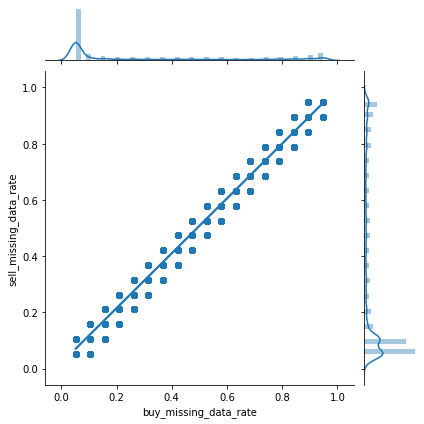

In [55]:
#Univariate Product Time Series Missing Data Distribution - Buy and Sell Flow
sns.jointplot("buy_missing_data_rate", "sell_missing_data_rate", data=time_series_length, kind="reg")

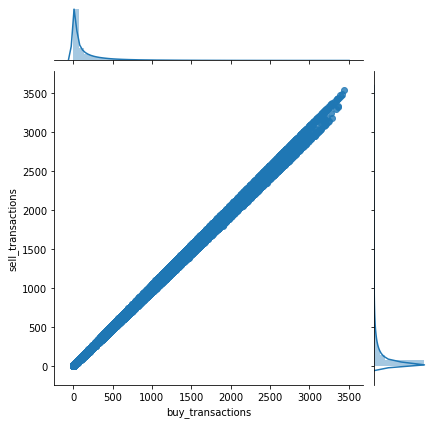

In [56]:
# "Univariate Product Time Series Transactions Distribution - Buy and Sell Flow"
sns.jointplot("buy_transactions", "sell_transactions", data=time_series_length, kind="reg")


In [4]:
annual_aggregated_time_series = """

(SELECT 
year, "Sell" as operation, origin as country, count(1) as transactions, 
FROM `silent-elevator-193921.OEC_DataSources.n0_year_origin_destination_hs96_6`
group by 1,2,3)

union all 

(SELECT 
year, "Buy" as operation, dest as country, count(1) as transactions
FROM `silent-elevator-193921.OEC_DataSources.n0_year_origin_destination_hs96_6` 
group by 1,2,3)

"""


annual_time_series = pd.read_gbq(annual_aggregated_time_series, project_id="silent-elevator-193921", dialect='standard', credentials=credentials)

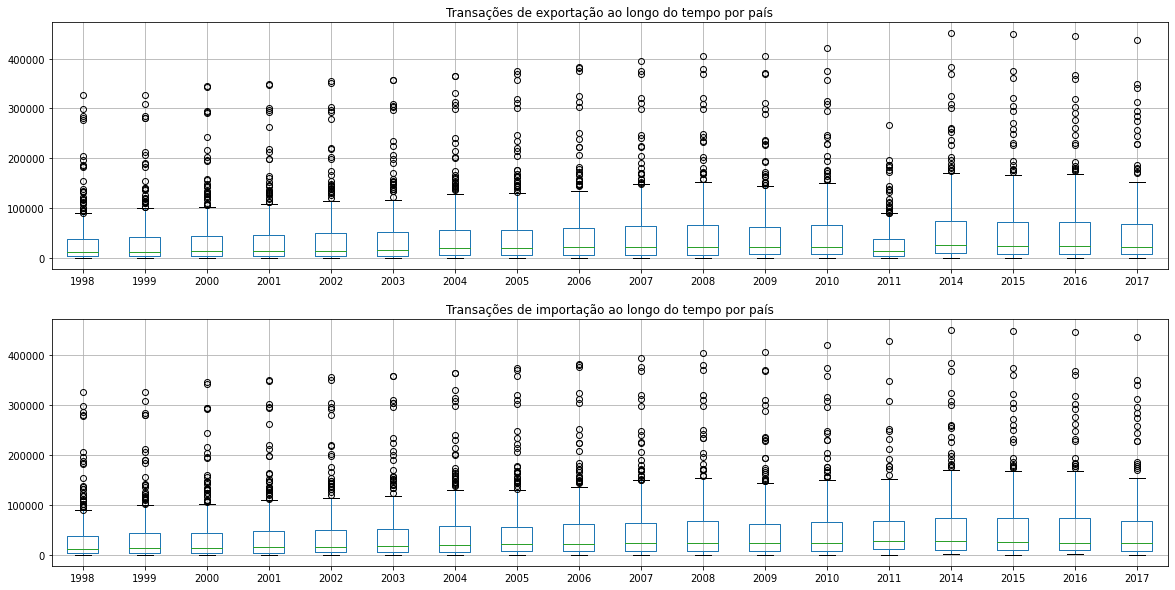

In [10]:
#annual_time_series.describe()
fig, axes = plt.subplots(figsize=(20,10), nrows=2)

g = pd.pivot_table(data=annual_time_series.query("operation == 'Buy' "), index=["country"], columns=["year"], values="transactions", aggfunc="sum").boxplot(ax=axes[0])
g.set_title("Transações de exportação ao longo do tempo por país")

g = pd.pivot_table(data=annual_time_series.query("operation == 'Sell' "), index=["country"], columns=["year"], values="transactions", aggfunc="sum").boxplot(ax=axes[1])
g.set_title("Transações de importação ao longo do tempo por país")

plt.show()

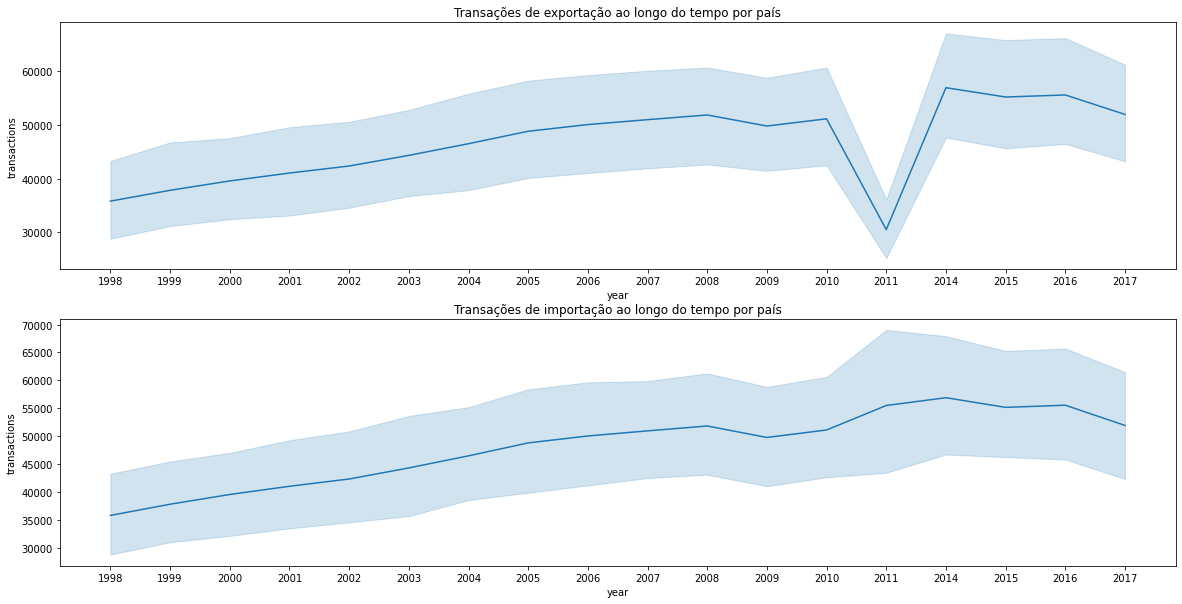

In [9]:
fig, axes = plt.subplots(figsize=(20,10), nrows=2)

g = sns.lineplot(x="year", y="transactions", data=annual_time_series.query("operation=='Buy'"), ax=axes[0])
g.set_title("Transações de exportação ao longo do tempo por país")

g = sns.lineplot(x="year", y="transactions", data=annual_time_series.query("operation=='Sell'"), ax=axes[1])
g.set_title("Transações de importação ao longo do tempo por país")


plt.show()

### 3.c) Distribuição dos valores de séries temporais e séries de retorno

In [12]:
Country_n_Product_Time_Series_Query = """ 

with 
-- produto cartesiano entre ano, produto e países


-- séries temporais, preenchidas por 0, quando não houver registro
time_series as (
SELECT 
 year, origin as country, hs96, sum(coalesce(cast(export_val as float64),0.0)) as financial_volume 
FROM
    `silent-elevator-193921.OEC_DataSources.n0_year_origin_destination_hs96_6` as hs 
group by 1,2,3
)

select 
country, hs96, 
avg(financial_volume) as average, 
min(financial_volume) as minimal, 
max(financial_volume) as maximal, 

from 
    time_series 
group by 1,2        
        



"""

Country_n_Product_Time_Series = pd.read_gbq(Country_n_Product_Time_Series_Similarity_Query, 
                                         project_id="silent-elevator-193921", 
                                                 dialect='standard', credentials=credentials)

In [14]:
Country_n_Product_Time_Series.describe()

,average,minimal,maximal
count,1043903.000000,1043903.000000,1043903.000000
mean,10984274.940014,3128347.957084,25292352.202750
std,308590072.062004,84244906.314040,808447869.550274
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,7585.161667,0.000000,46745.000000
75%,217545.938366,1879.590000,984504.685000
max,171956257673.036621,31288188122.489998,501985703245.739990


In [17]:
Country_n_Product_Return_Time_Series_Query = """ 

with 
-- produto cartesiano entre ano, produto e países


-- séries temporais, preenchidas por 0, quando não houver registro
time_series as (
SELECT 
 year, origin as country, hs96, sum(coalesce(cast(export_val as float64),0.0)) as financial_volume 
FROM
    `silent-elevator-193921.OEC_DataSources.n0_year_origin_destination_hs96_6` as hs 
group by 1,2,3
)

select 
a.country, a.hs96, 
avg((1+a.financial_volume - b.financial_volume)/(1+b.financial_volume)) as average, 
min((1+a.financial_volume - b.financial_volume)/(1+b.financial_volume)) as minimal, 
max((1+a.financial_volume - b.financial_volume)/(1+b.financial_volume)) as maximal, 
max((1+a.financial_volume - b.financial_volume)/(1+b.financial_volume)) as standard_deviation

from 
    time_series as a 
    join 
    time_series as b 
    on b.country = a.country and a.hs96 = b.hs96 and (cast(a.year as int64) - 1) = cast(b.year as int64)
    
group by 1,2        
        



"""

Country_n_Product_Return_Time_Series = pd.read_gbq(Country_n_Product_Return_Time_Series_Query, 
                                         project_id="silent-elevator-193921", 
                                                 dialect='standard', credentials=credentials)

In [18]:
Country_n_Product_Return_Time_Series.describe()

,average,minimal,maximal,standard_deviation
count,921177.000000,921177.000000,921177.000000,921177.000000
mean,14484.958340,589.657724,141243.860184,141243.860184
std,771910.302149,131665.079165,7363149.258193,7363149.258193
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.844657,-0.999819,1.000000,1.000000
50%,1.482478,-0.910114,12.082432,12.082432
75%,1376.496400,-0.076012,12729.170000,12729.170000
max,437220731.953710,85715903.000000,3060545124.200000,3060545124.200000


### 3.D) Distancia de todos para todos 

In [7]:
Same_Products_Time_Series_Similarity_Query = """ 


with 
-- produto cartesiano entre ano, produto e países


-- séries temporais, preenchidas por 0, quando não houver registro
time_series as (
SELECT 
 year, origin as country, hs96, sum(coalesce(cast(export_val as float64),0.0)) as financial_volume 
FROM
    `silent-elevator-193921.OEC_DataSources.n0_year_origin_destination_hs96_6` as hs 
group by 1,2,3
)

select 
hs96, 
avg(euclidean_distance) as average_euclidean_distance, 
stddev(euclidean_distance) as euclidean_distance_standard_deviation, 
min(euclidean_distance) as minimal_euclidean_distance, 
max(euclidean_distance) as maximal_euclidean_distance,
avg(manhattan_distance) as average_manhattan_distance, 
stddev(manhattan_distance) as manhattan_distance_standard_deviation, 
min(manhattan_distance) as minimal_manhattan_distance, 
max(manhattan_distance) as maximal_manhattan_distance from (
    select 
    a.country, hs96, 
    sqrt(sum( (a.financial_volume - b.financial_volume)*(a.financial_volume - b.financial_volume) )) as euclidean_distance,
    sum( abs(a.financial_volume - b.financial_volume) ) as manhattan_distance
    
    from 
        time_series as a
    join 
        time_series as b
    using (year, hs96)
    where a.country != b.country
    group by 1,2
) group by 1 


"""

Same_Products_Time_Series_Similarity = pd.read_gbq(Same_Products_Time_Series_Similarity_Query, 
                                         project_id="silent-elevator-193921", 
                                                 dialect='standard', credentials=credentials)

In [8]:
Same_Products_Time_Series_Similarity.describe()

,average_euclidean_distance,euclidean_distance_standard_deviation,minimal_euclidean_distance,maximal_euclidean_distance,average_manhattan_distance,manhattan_distance_standard_deviation,minimal_manhattan_distance,maximal_manhattan_distance
count,5111.000000,5111.000000,5111.000000,5111.000000,5111.000000,5111.000000,5111.000000,5111.000000
mean,3667262343.260874,2929952831.371436,430033565.264180,36937900248.597221,58668520671.759735,150508465387.481995,1546263120.075234,1750375560951.803711
std,21370322274.466934,16837135955.630005,2281772240.027094,223512159133.538879,373988154725.836731,833110530440.820923,12682556267.125185,9988160881622.091797
min,634227.106385,431019.251553,1057.000000,2990199.788227,3523507.650667,4787650.184490,1057.000000,26670043.070000
25%,250665567.476947,210788014.340970,27941218.286843,2274929627.562627,3389398394.315864,8786707041.298100,78018972.450000,88864049771.790009
50%,750902672.498293,616781508.187987,89078230.876934,7076805446.580238,11287502946.530045,29295804777.474930,251556321.220000,314453783062.170044
75%,2330620382.479954,1882151367.690238,274140303.021296,22831165954.757744,35393626148.849983,94563741477.048355,760395998.655000,1065053865242.999756
max,1024471363963.250977,821597577463.121216,71676639159.437775,11050290639896.806641,18185818444461.367188,37627386394160.023438,497466304761.880127,464978387386862.187500
